# Tarea 8. Aprendizaje no supervisado

En este ejercicio utilizaremos un dataset con información sobre publicaciones en facebook (tipo, fecha y reacciones) con el fin de organizarlas en clusters que nos permitan extraer conclusiones provechosas sobre los datos. Así, el ejercicio lo divideremos en: 
1. Importación, limpieza y descripción del dataset
2. Preprocesamiento
3. Clusterización con Kmeans y descripción de sus resultados
4. Clusterización jerárquica y descripción de sus resultados 
5. Comparación entre las dos clusterizaciones y conclusiones 

# 1. Importación, limpieza y descripción del dataset

In [57]:
#importamos las librerías necesarias para este ejercicio
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator 
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering


plt.rcParams['figure.autolayout'] = True
import warnings
warnings.filterwarnings("ignore")

In [2]:
#importamos el dataset
df=pd.read_csv('Publicacions Facebook Thailandia.csv', sep=',')

In [3]:
#echamos un ojo al dataset con el método head
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


Observamos un data set que describe publicaciones de facebook según su tipo, fecha de públicación y reacciones. De manera preliminar podemos encontrar: 
- cuatro columnas vacías 
- 9 columnas númericas que contienen la cantidad de reacciones de cada publicación 
- una columna categoríca que indica el tipo de publicación 
- fecha y hora de la publicación 
- una columna status_id que funciona como índice del dataset 

Según la descripción preliminar del dataset (sabiendo que no existe ninguna columna que actúe como label), en este ejercicio nos propondremos como objetivo realizar aplicar modelos de aprendizaje no supervisado para averiguar la mejor forma de agrupación de los datos.

Además, describiremos los clusters y averiguaremos si existen diferencias entre los clusters producidos por el algoritmo K-Means y por el clustering jerárquico. 

In [4]:
#confirmamos los types de las columnas mediante el método info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

Teniendo en cuenta los resultados de .head() y de .info() haremos: 
- eliminar las cuatro columnas vacías 
- convertir status_id en indíce (al no tener datos nulos después de eliminar las columnas vacías el index no se modificará)
- convertir la columna "status_published" en date y extraer su información (hora, día de la semana, mes, año) 

In [5]:
#eliminamos las columas vacías
df.drop(columns=['Column1', 'Column2', 'Column3', 'Column4'], inplace=True)

In [6]:
#establecemos la columna 'status_id' como el índice
df.set_index('status_id', inplace=True)

In [7]:
#cambiamos el datatype de 'status_published'
df['status_published'] = pd.to_datetime(df['status_published'], format='%m/%d/%Y %H:%M')

#extraemos el año en una nueva columna
df['año'] = df['status_published'].dt.year.astype(str)

#extraemos los nombres de los meses y creamos una columna nueva
df['mes'] = df['status_published'].dt.month_name()

#extraemos los días de publicación y creamos una columna nueva
df['dia'] = df['status_published'].dt.day_name()

#creamos nueva columna para la hora del día 
df['hora'] = df['status_published'].dt.hour

#contruimos un diccionario con parejas de hora-categoría
mapeo_hora_categoria = {
    0: 'noche',
    1: 'noche',
    2: 'noche',
    3: 'noche',
    4: 'noche',
    5: 'mañana',
    6: 'mañana',
    7: 'mañana',
    8: 'mañana',
    9: 'mañana',
    10: 'mañana',
    11: 'mañana',
    12: 'mañana',
    13: 'tarde',
    14: 'tarde',
    15: 'tarde',
    16: 'tarde',
    17: 'tarde',
    18: 'tarde',
    19: 'tarde',
    20: 'tarde',
    21: 'noche',
    22: 'noche',
    23: 'noche'
}

#creamos una nueva columna 'categoria_hora' y mapeamos el diccionario con las categorías
df['categoria_hora'] = df['hora'].map(mapeo_hora_categoria)

#borramos las columnas sobrantes
df.drop(columns=['status_published', 'hora'], inplace=True)

In [8]:
#comprobamos que el dataset no tenga nulos 
#investigamos si el dataset tiene nulos
nulos = df.isnull().sum()

if nulos.all() == 0: 
    print("El dataset no tiene nulos")
else: 
    print("El dataset tiene nulos")

#revisamos las dimensiones del dataset
rows, cols = df.shape
print("El dataframe tiene", rows, "filas y", cols, "variables.")

El dataset no tiene nulos
El dataframe tiene 7050 filas y 14 variables.


In [9]:
#realizamos una descripción estadística básica del data set con el metodo describe
df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,230.117163,224.356028,40.022553,215.043121,12.728652,1.289362,0.696454,0.243688,0.113191
std,462.625309,889.636820,131.599965,449.472357,39.972930,8.719650,3.957183,1.597156,0.726812
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.500000,4.000000,0.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,219.000000,23.000000,4.000000,184.750000,3.000000,0.000000,0.000000,0.000000,0.000000
max,4710.000000,20990.000000,3424.000000,4710.000000,657.000000,278.000000,157.000000,51.000000,31.000000


Con la descripción estadística podemos concluir que: 
   - Examinando los quartiles 75% - max nos damos cuenta que todas las columnas presentan un skew hacia la derecha por cuanto hay una gran diferencia entre el 75% y el máximo. Por ejemplo, en el caso de num_hahas todas sus observaciones están ubicadas en este cuartil (75% es 0 y máx es 157) 
   - Esto nos lleva a concluir que en el conjunto de reacciones, comentarios y shares de cada publicación hay outliers que, suponemos, corresponden a las publicaciones virales. La presencia de dichos outliers también nos llevan a pensar que en la estandarización de las columnas numéricas tendremos que usar el método RobustScaler. 
   - También podemos determinar que la columna 'num_reactions' es la suma de todas las reacciones. Para no tener información duplicada eliminaremos dicha columna y trabajaremos con las reacciones discriminadas. 
   - Finalmente, podemos observar que las medias de reacciones y comentarios son similares, pero la de shares es mucho más baja. 
   
Haremos un conjunto de histogramas para comprobar la distribución de las variables

In [10]:
#eliminamos 'num_reactions'
df.drop(columns=['num_reactions'], inplace=True)

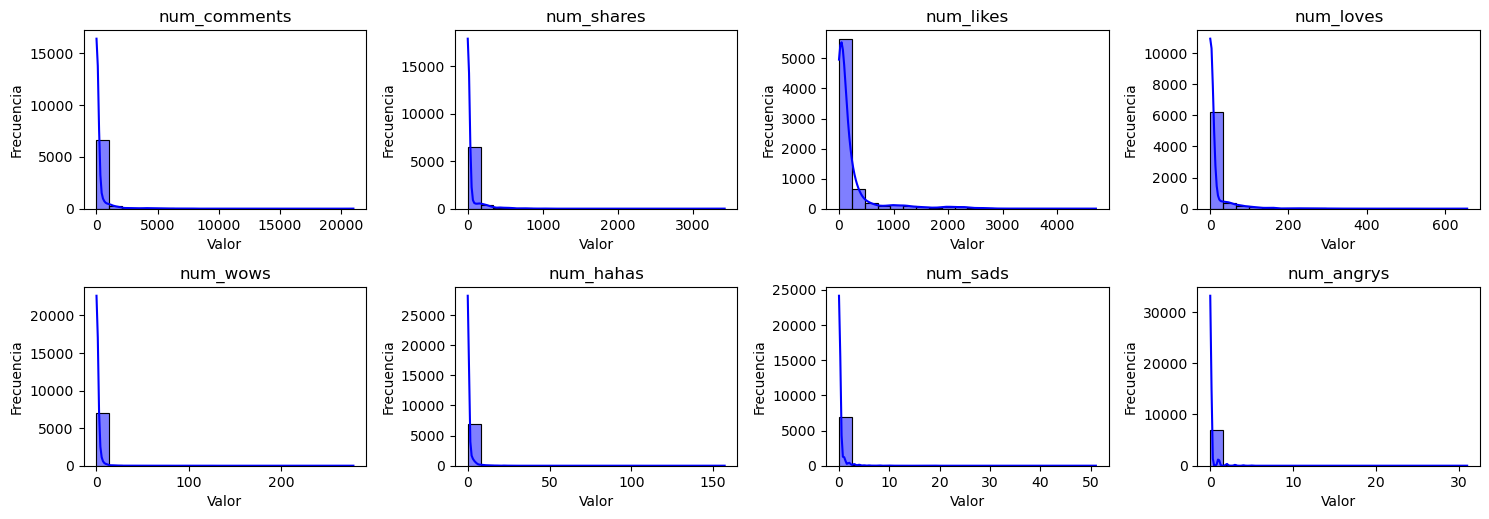

In [11]:
#creamos la figura
plt.figure(figsize=(15, 10))

#creamos un objeto que agrupe las columnas numericas
columnas_numericas = ['num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

#iteramos sobre cada columna en df y creamos un histograma
for i, column in enumerate(columnas_numericas):
    plt.subplot(4, 4, i + 1) 
    sns.histplot(df[column], bins=20, kde=True, color='blue', edgecolor='black')
    plt.title(column)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Los histogramas nos permiten comprobar que todas las columnas numéricas tienen un skew a la derecha lo que significa la existencia de outliers en sus valores máximos. Como ya lo mencioné antes esto tiene que ver con la existencia de publiaciones virales. 

Ahora bien, haremos una breve descripción gráfica del dataset que luego será complementada con la información resultante de los modelos de aprendizaje no supervisado.

Nos concentraremos en observar: 
- Distribución de los tipos publicación
- Distribuciones de los tipos de publicacion según año, mes, días, horas

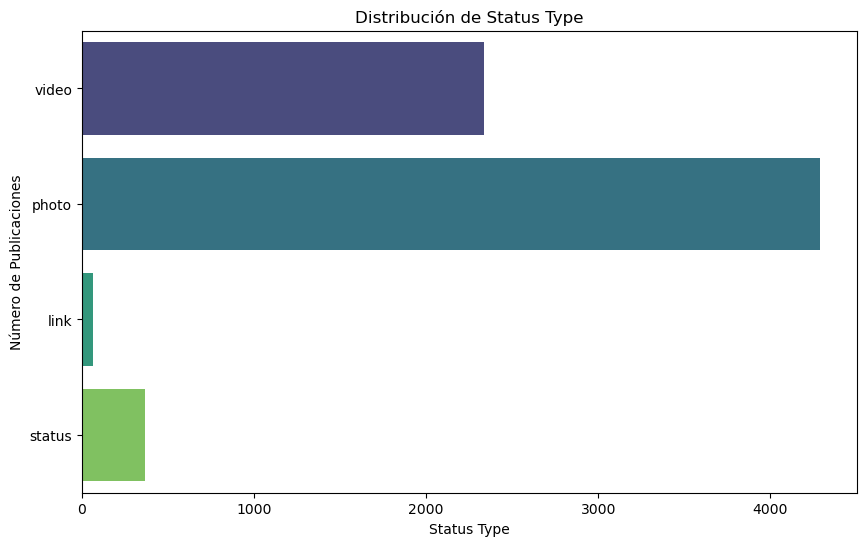

In [12]:
#Distribución por tipos de publicación 

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='status_type', palette='viridis')

plt.title('Distribución de Status Type')
plt.xlabel('Status Type')
plt.ylabel('Número de Publicaciones')

plt.show()

Podemos observar que las categorías de publicaciones más pobladas son photos y videos. Por el contrario, la categoría 'link' es casi marginal. 

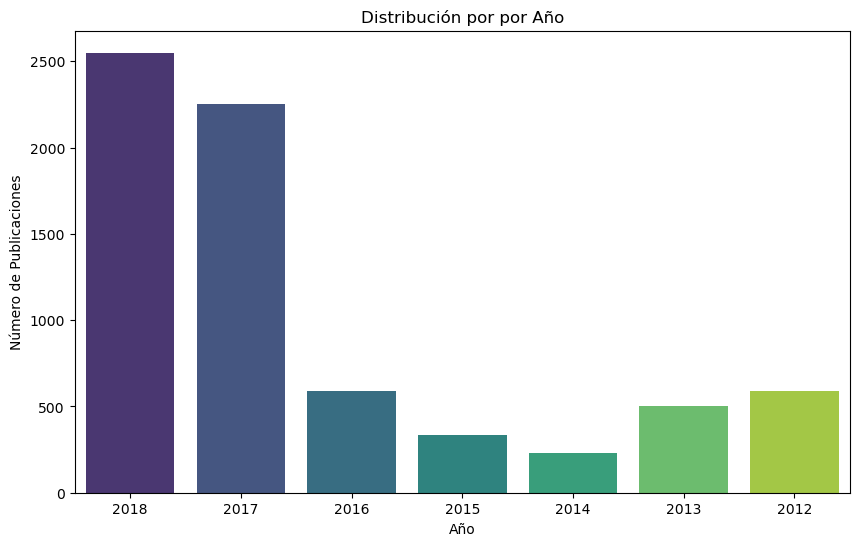

In [13]:
#Distribución por año

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='año', palette='viridis')

plt.title('Distribución por por Año')
plt.xlabel('Año')
plt.ylabel('Número de Publicaciones')

plt.show()

Observamos que la evolución de las publicaciónes no ha sido lineal en el tiempo. Los años 2015 y 2014 presentaron una curva descendente mientras que en 2017 y 2018 el ascenso ha sido bastante pronunciado.

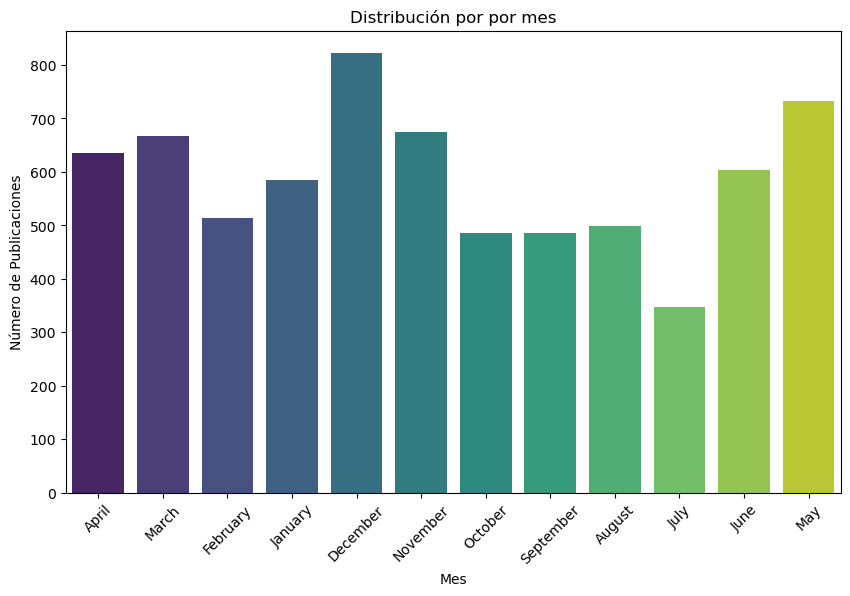

In [14]:
#Distribución por mes

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='mes', palette='viridis')

plt.title('Distribución por por mes')
plt.xlabel('Mes')
plt.ylabel('Número de Publicaciones')
plt.xticks(rotation=45)

plt.show()

Los meses en que más se realizan publicaciones son diciembre y mayo. Julio se destaca por ser un mes en el que se hacen el menor número de publicaciones

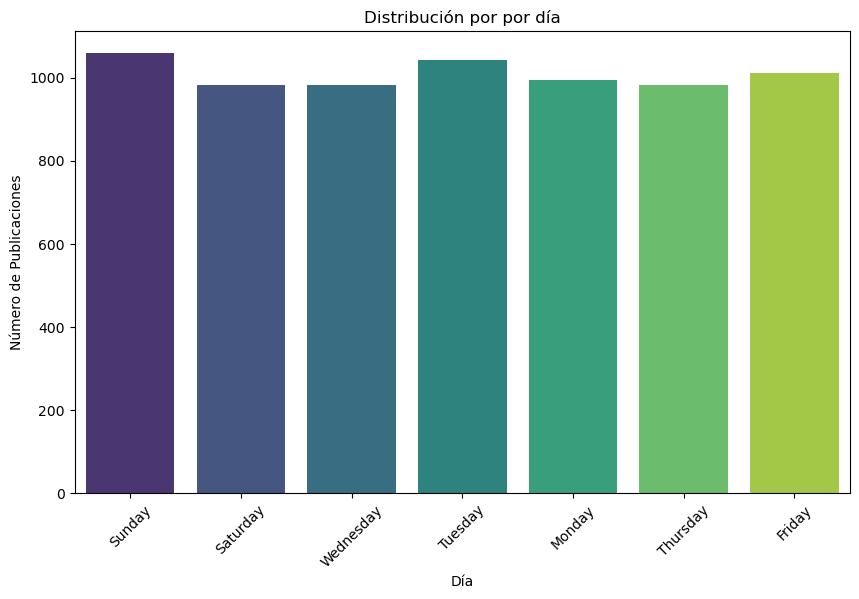

In [15]:
#Distribución por día

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dia', palette='viridis')

plt.title('Distribución por por día')
plt.xlabel('Día')
plt.ylabel('Número de Publicaciones')
plt.xticks(rotation=45)

plt.show()

La distribución de las publicaciones en los días de la semana es uniforme, aunque los domingos y los martes se realizan un poco más

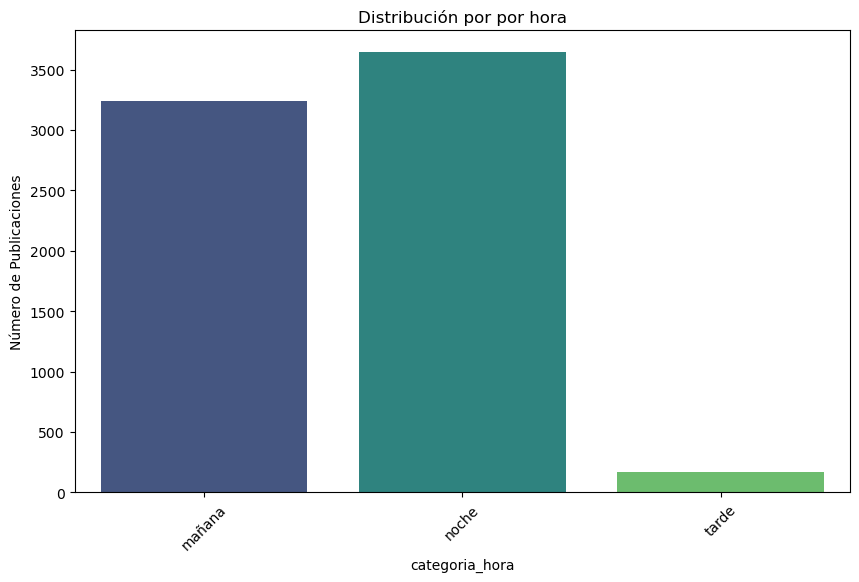

In [16]:
#Distribución por hora

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='categoria_hora', palette='viridis')

plt.title('Distribución por por hora')
plt.ylabel('Número de Publicaciones')
plt.xticks(rotation=45)

plt.show()

El mayor número de publicaciones se realizan en horas de la noche. Es importante subrayar durante la tarde las publicaciones sufren una disminución considerable

## 1. Preprocesamiento

La descripción del dataset nos ha dado algunas pistas para realizar el preprocesamiento. Teniendo en cuenta que los modelos de aprendizaje no supervisaje nos exijen que los datos esten estandarizados realizaremos los siguientes procedimientos: 
1. Estandarizaremos las columnas numericas con el método RobustScaler pues en la descripción detectamos la presencia de numerosos outliers
2. Las columnas categóricas las volveremos dummies. 

Antes de realizar los procedimientos crearemos una copia del dataset. 

In [18]:
df_scaler = df.copy()

In [19]:
#creamos un objeto que agrupe las variables numéricas
columnas_numericas = ['num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

#creamos un objeto que agrupe las variables categórica
columnas_categoricas = ['status_type', 'año', 'mes', 'dia', 'categoria_hora']

# estandarizamos las variables numéricas
scaler = RobustScaler()
df_scaler[columnas_numericas] = scaler.fit_transform(df_scaler[columnas_numericas])

# creamos columnas dummies para las variables categóricas
df_dummies = pd.get_dummies(df_scaler[columnas_categoricas], drop_first=True)


df_scaler = pd.concat([df_scaler, df_dummies], axis=1)


df_scaler[df_dummies.columns] = df_scaler[df_dummies.columns].astype(int)

df_scaler.drop(columns=['status_type', 'año', 'mes', 'dia', 'categoria_hora'], inplace=True)


In [20]:
df_scaler.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7050 entries, 246675545449582_1649696485147474 to 1050855161656896_1050858841656528
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num_comments          7050 non-null   float64
 1   num_shares            7050 non-null   float64
 2   num_likes             7050 non-null   float64
 3   num_loves             7050 non-null   float64
 4   num_wows              7050 non-null   float64
 5   num_hahas             7050 non-null   float64
 6   num_sads              7050 non-null   float64
 7   num_angrys            7050 non-null   float64
 8   status_type_photo     7050 non-null   int64  
 9   status_type_status    7050 non-null   int64  
 10  status_type_video     7050 non-null   int64  
 11  año_2013              7050 non-null   int64  
 12  año_2014              7050 non-null   int64  
 13  año_2015              7050 non-null   int64  
 14  año_2016         

Nuestro dataset preprocesado cuenta con el mismo número de observaciones pero ahora tenemos 36 columnas, todas ellas numéricas. 

# 3. Clusterización con Kmeans y descripción de sus resultados 

Para realizar la clusterización con kmeans primero determinaremos el número correcto de k a través del método del codo y del método Silhouette

Luego obtendremos la lista de los clusters producidos por kmeans que concatenaremos con nuestro dataset limpio para describir cada uno de los clusters. 

Finalmente, realizaremos una descripción gráfica de los clusters teniendo en cuenta la descripción general del dataset

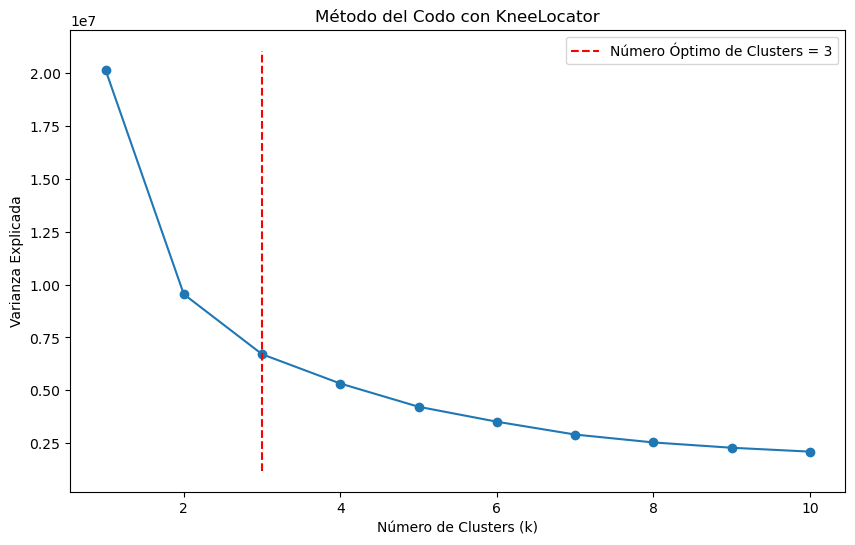

Número óptimo de clusters identificado por KneeLocator: 3


In [21]:
#creamos una lista vacía que popularemos con los valores de las iteraciones
variances = []

#estableceremos el rango de valores a probar
k_values = range(1, 11)

#aplicamos kmeans para los diferentes valores de k 
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaler)
    variances.append(kmeans.inertia_)

#utilizamos kneelocator para determinar el mejor valor de k
knee_locator = KneeLocator(k_values, variances, curve='convex', direction='decreasing')
optimal_k = knee_locator.elbow

#graficamos el método de codo y trazamos una línea que nos indique el mejor valor de k 
plt.figure(figsize=(10, 6))
plt.plot(k_values, variances, marker='o')
plt.title('Método del Codo con KneeLocator')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Varianza Explicada')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Número Óptimo de Clusters = {optimal_k}')
plt.legend()
plt.show()

print(f"Número óptimo de clusters identificado por KneeLocator: {optimal_k}")

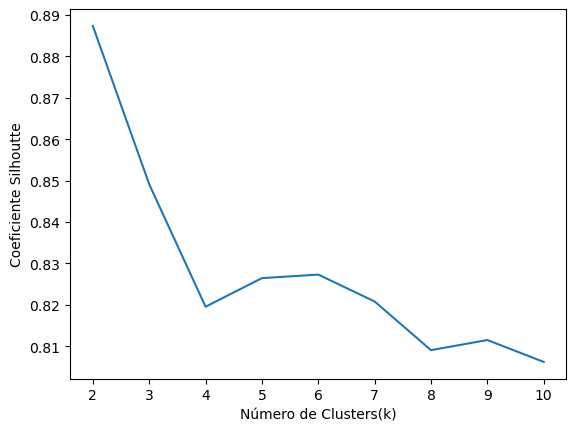

In [22]:
#creamos una lista que será populada por los valores de los coeficientes de silhoutte para cada k
coeficientes_silhouette = []

#iteramos el kmeans sobre cada valor de k
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaler)
    score = silhouette_score(df_scaler, kmeans.labels_)
    coeficientes_silhouette.append(score)

#graficamos el método
plt.plot(range(2, 11), coeficientes_silhouette)
plt.xticks(range(2, 11))
plt.xlabel("Número de Clusters(k)")
plt.ylabel("Coeficiente Silhoutte")
plt.show()

Con el método silhouette el valor más alto de su coeficiente es de 2. Este en principio sería le número de k. Sin embargo, podríamos también utilizar 3, teniendo en cuenta que la diferencia entre los dos coeficientes no es muy amplia (2 = 0.89; 3 0.85) 

In [24]:
#desplegamos el método kmeans con el número de k escogido 
kmeans = KMeans(n_clusters=3).fit(df_scaler)

#predecimos los labels 
labels = kmeans.predict(df_scaler)

#creamos una nueva columna en nuestro dataset limpio con los valores de los labels
df['label'] = labels

## Descripción de los clusters

En esta sección intentaremos realizar una descripción gráfica de los clusters teniendo en cuenta:

- el tamaño de cada uno de los clusters y su relación con el conjunto total de datos 
- su distribución por tipos de publicación
- su distribución por reacciones 
- su distribución por fechas

Finalmente intentaremos sintentizar las diferencias entre cada uno de los clusters

Cluster 0: 6490 observaciones
Cluster 1: 487 observaciones
Cluster 2: 73 observaciones


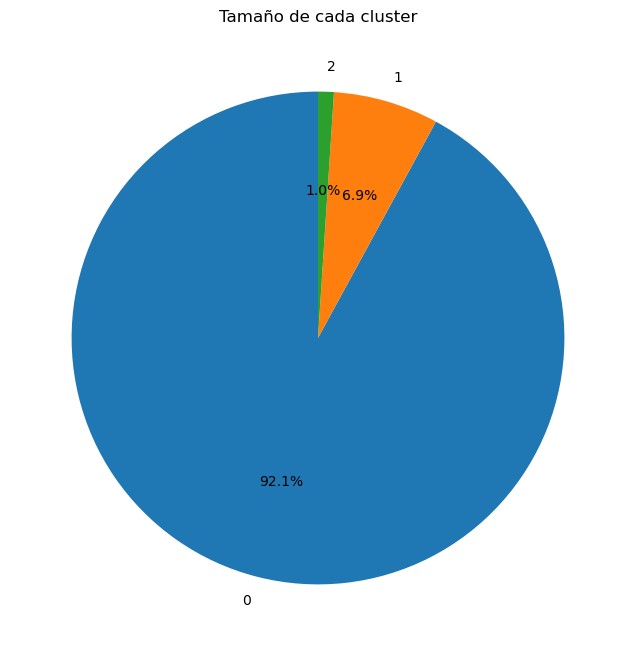

In [26]:
#contamos el número de observaciones por cluster
cluster_counts = df['label'].value_counts()
messages = [f'Cluster {label}: {count} observaciones' for label, count in cluster_counts.items()]

#imprimimos la información
for message in messages:
    print(message)

#creamos un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)

#configuramos el título
plt.title('Tamaño de cada cluster')

# Mostrar el gráfico
plt.show()

Según el gráfico de pie y la tabla de distribución el kmeans construyó 3 clusters: 
   - El cluster 0 contiene la mayor cantidad de observaciones del conjunto de datos
   - Los clusters 1 y 2 representan solo el 8% del data set. 
   
Teniendo en cuenta que las diferencias de tamaño entre cada cluster son tan grandes, la siguiente información la visualizaremos con gráficos de barras apiladas 100% para no tener en cuenta la escala. 

<Figure size 1200x800 with 0 Axes>

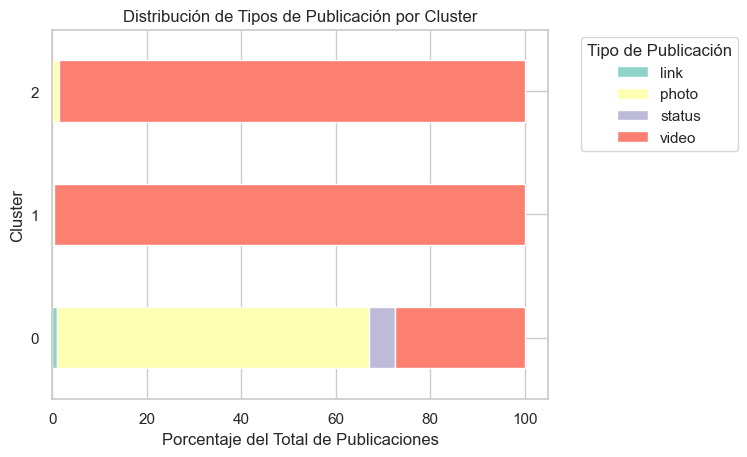

In [28]:
#Distribución de los tipos de publicación en cada cluster 

#escogemos los colores 
colores = sns.color_palette('Set3', n_colors=len(df['status_type'].unique()))

#contamos el tipo de publicación por cluster
conteo_tipo_publicacion = df.groupby(['label', 'status_type']).size().unstack()

#normalizamos
conteo_tipo_porcentaje = conteo_tipo_publicacion.div(conteo_tipo_publicacion.sum(axis=1), axis=0) * 100

#escogemos un estilo 
sns.set(style="whitegrid")

#creamos el gráfico
plt.figure(figsize=(12, 8))
conteo_tipo_porcentaje.plot(kind='barh', stacked=True, color=colores)

#configuramos
plt.title('Distribución de Tipos de Publicación por Cluster')
plt.xlabel('Porcentaje del Total de Publicaciones')
plt.ylabel('Cluster')

# Ajustar leyenda
plt.legend(title='Tipo de Publicación', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

Según el tipo de publicación podemos afirmar que: 
- El cluster 0 contiene todos los tipos de publicación más o menos con la misma distribución del dataset original. Siempre tenemos que tener en cuenta que el gran tamaño del cluster 0 implica que la distribución de sus datos sea muy similar a la distribución del datasetoriginal.
- El cluster 1 contiene principalmente observaciones de video, y un pequeño porcentaje de photo
- El cluster 2 contiene principalmente observacione de video y un porcentaje pequeño, aunque un poco más grande que el del cluster 1, de observaciones de photo. 

In [29]:
#Distribución por reacciones (columnas numéricas)

#calculamos los valores medios por cada columna
mean_values = df.groupby('label')[columnas_numericas].mean()

print(mean_values)

       num_comments  num_shares   num_likes   num_loves   num_wows  num_hahas  \
label                                                                           
0         50.165177   10.490139  200.316795    4.462404   0.629122   0.289522   
1       1579.455852  334.667351  364.383984  103.318275   8.655031   4.893224   
2       6670.452055  699.931507  527.986301  143.287671  10.849315   8.876712   

       num_sads  num_angrys  
label                        
0      0.152388    0.055778  
1      1.039014    0.710472  
2      3.054795    1.232877  


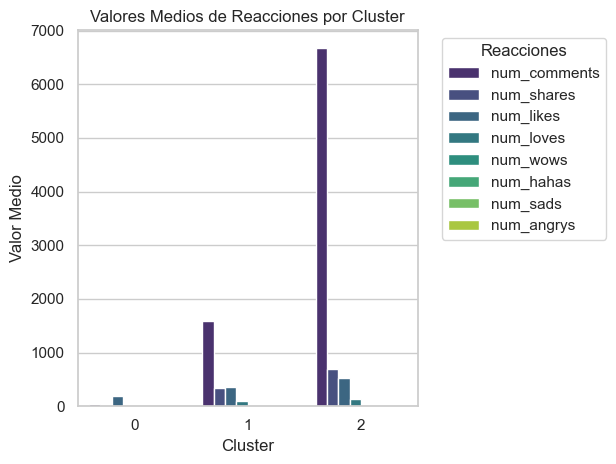

In [39]:
#determinamos la media de reacciones por cluster 
media_reacciones = df.groupby('label')[columnas_numericas].mean().reset_index()


#creamos un gráfico de barras agrupadas
plt.figure()
sns.barplot(data=media_reacciones.melt(id_vars='label'), x='label', y='value', hue='variable', palette='viridis')

#configuramos el gráfico
plt.title('Valores Medios de Reacciones por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Valor Medio')
plt.legend(title='Reacciones', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Teniendo en cuenta la tabla y la gráfica podemos decir que: 
- El cluster 0 contiene las publicaciones con las media más pequeña para los valores de todas las reacciones
- El cluster 1 agrupa las publicaciones con valores de reacciones ni tan grandes ni tan pequeños 
- El cluster 2 agrupa las publicaciones con los valores medios más grandes de todas las reacciones

Podemos decir que según las reacciones podríamos clasificar los clusters en: 
    - cluster 0: no virales
    - cluster 1: populares
    - cluster 2: virales 
    
Teniendo en cuenta esta clasificación, podríamos intentar visualizar los datos en un scatter utilizando las columnas de reacciones más comunes (shares y comments) 

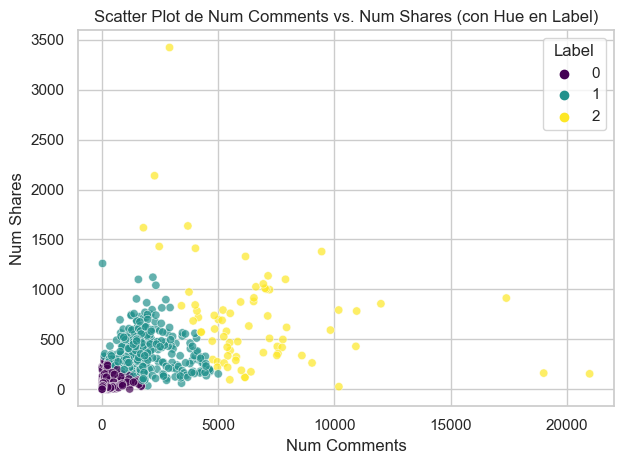

In [41]:
#creamos el scatter con comments y shares
sns.scatterplot(x='num_comments', y='num_shares', hue='label', data=df, alpha=0.7, palette='viridis')

#configuramos el gráfico
plt.title('Scatter Plot de Num Comments vs. Num Shares (con Hue en Label)')
plt.xlabel('Num Comments')
plt.ylabel('Num Shares')
plt.legend(title='Label')

plt.show()

Efectivamente, el scatter nos muestra que el kmeans agrupó las publicaciones según el número de comentarios y el número de shares. Es decir, podemos pensar que uno de los principales criterios que utilizó nuestro algoritmo para agrupar las publicaciones fue su viralidad (medida en la cantidad de reacciones). 

Continuaremos ahora las evaluaciones de cada cluster respecto de las fechas. Para esto también utilizaremos gráficas de barras 100%

<Figure size 1200x800 with 0 Axes>

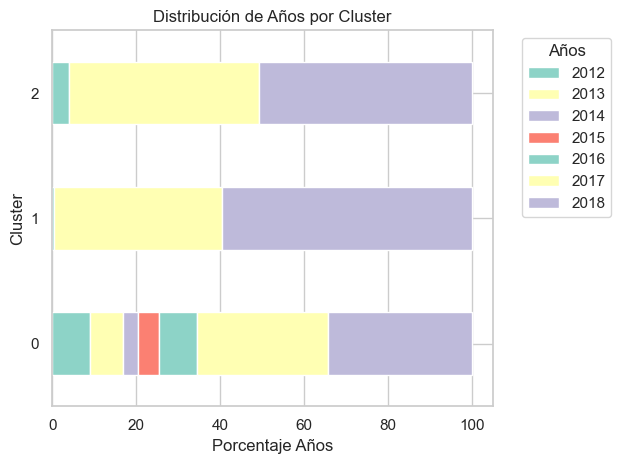

In [44]:
#distribución por año 

#escogemos los colores 
colores = sns.color_palette('Set3', n_colors=len(df['status_type'].unique()))

#contamos el tipo de publicación por cluster
conteo_año = df.groupby(['label', 'año']).size().unstack()

#normalizamos
conteo_año_porcentaje = conteo_año.div(conteo_año.sum(axis=1), axis=0) * 100

#escogemos un estilo 
sns.set(style="whitegrid")

#creamos el gráfico
plt.figure(figsize=(12, 8))
conteo_año_porcentaje.plot(kind='barh', stacked=True, color=colores)

#configuramos
plt.title('Distribución de Años por Cluster')
plt.xlabel('Porcentaje Años')
plt.ylabel('Cluster')

# Ajustar leyenda
plt.legend(title='Años', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

Según los años: 
   - Cluster 0: distribución similar al dataset original. Incluye todos los años desde 2012 hasta 2018
   - Cluster 1: solo incluye publicaciones de los años 2017 y 2018
   - Cluster 2: incluye publicaciones de los años 2017 y 2018 y un porcentaje muy pequeño de publicaciones de 2012

<Figure size 1200x800 with 0 Axes>

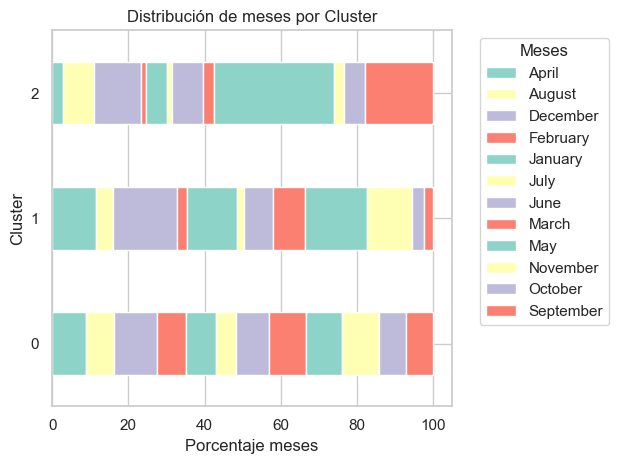

In [47]:
#distribución por mes 

#escogemos los colores 
colores = sns.color_palette('Set3', n_colors=len(df['status_type'].unique()))

#contamos el tipo de publicación por cluster
conteo_mes = df.groupby(['label', 'mes']).size().unstack()

#normalizamos
conteo_mes_porcentaje = conteo_mes.div(conteo_mes.sum(axis=1), axis=0) * 100

#escogemos un estilo 
sns.set(style="whitegrid")

#creamos el gráfico
plt.figure(figsize=(12, 8))
conteo_mes_porcentaje.plot(kind='barh', stacked=True, color=colores)

#configuramos
plt.title('Distribución de meses por Cluster')
plt.xlabel('Porcentaje meses')
plt.ylabel('Cluster')

# Ajustar leyenda
plt.legend(title='Meses', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

Según los meses los tres clusters contienen publicaciones de todos los meses del año. Tal vez lo único relevante sea que el cluster 2 contiene más observaciones pretenecientes a Enero. 

<Figure size 1200x800 with 0 Axes>

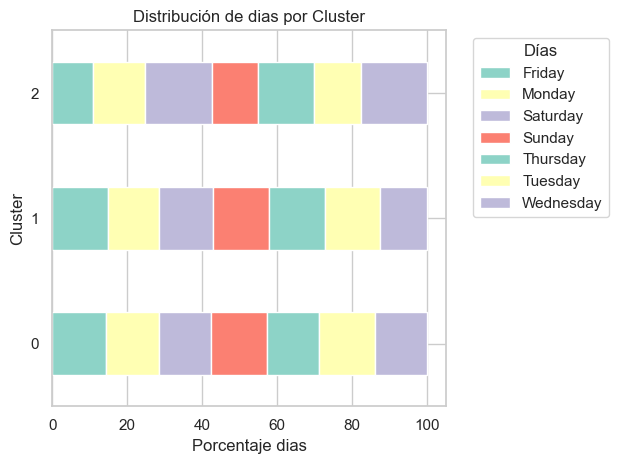

In [48]:
#distribución por día de la semana

#escogemos los colores 
colores = sns.color_palette('Set3', n_colors=len(df['status_type'].unique()))

#contamos el tipo de publicación por cluster
conteo_dia = df.groupby(['label', 'dia']).size().unstack()

#normalizamos
conteo_dia_porcentaje = conteo_dia.div(conteo_dia.sum(axis=1), axis=0) * 100

#escogemos un estilo 
sns.set(style="whitegrid")

#creamos el gráfico
plt.figure(figsize=(12, 8))
conteo_dia_porcentaje.plot(kind='barh', stacked=True, color=colores)

#configuramos
plt.title('Distribución de dias por Cluster')
plt.xlabel('Porcentaje dias')
plt.ylabel('Cluster')

# Ajustar leyenda
plt.legend(title='Días', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

El contenido de cada cluster según día de la semana es similar

<Figure size 1200x800 with 0 Axes>

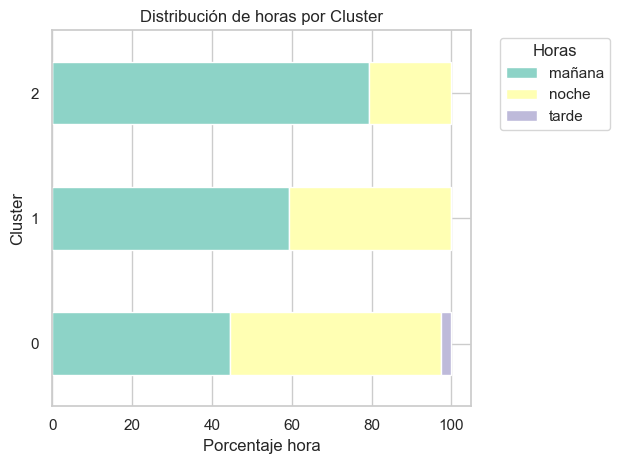

In [53]:
#distribución por hora 

#escogemos los colores 
colores = sns.color_palette('Set3', n_colors=len(df['status_type'].unique()))

#contamos el tipo de publicación por cluster
conteo_hora = df.groupby(['label', 'categoria_hora']).size().unstack()

#normalizamos
conteo_hora_porcentaje = conteo_hora.div(conteo_hora.sum(axis=1), axis=0) * 100

#escogemos un estilo 
sns.set(style="whitegrid")

#creamos el gráfico
plt.figure(figsize=(12, 8))
conteo_hora_porcentaje.plot(kind='barh', stacked=True, color=colores)

#configuramos
plt.title('Distribución de horas por Cluster')
plt.xlabel('Porcentaje hora')
plt.ylabel('Cluster')

# Ajustar leyenda
plt.legend(title='Horas', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

Según horas: 
    - Cluster 0: misma distribución del dataset original 
    - Cluster 1: 60% mañana, 40% noche
    - Cluster 2: 80% mañana, 20% noche 

En resumen, 

Cluster 0 - no viral: 
   - al representar el 92% del dataset original su contenido es muy parecido similar. Sin embargo, las medias de los valores de las columnas de las reacciones son inferiores a las del dataset original. Es decir, podríamos concluir que en este cluster se agrupan las gran cantidad de publicaciones que no se han viralizado
    
Cluster 1 - popular: 
   - representa el 7% del dataset 
   - las medias de los valores de las reacciones no son tan bajas como las del cluster 0, pero tampoco tan altas como las del cluster 2. 
   - incluye principalmente publicaciones de video hechas en los años 2017 y 2018
   
Cluster 2 - viral: 
- representa tan solo el 1% del dataset. 
- las medias de los valores de las reacciones son las mas altas. Es decir, este cluster agrupa principalmente las publicaciones más virales. 
- incluye publicaciones de video hechas principalmente en las mañanas de los años 2017, 2018 y algunas de 2012. 

# 4. Clusterización jerárquica y descripción de sus resultados 

Para realizar la clusterización jerárquica primero crearemos el dendrograma que nos permitirá establecer el número de k. 

Con este número aplicaremos el modelo, generaremos una lista con los labels que luego anexaremos a nuestro dataset original limpio. 

Finalmente, describiremos los clusters teniendo en cuenta solamente la información más relevante que obtuvimos con kmeans: 

- tamaño de los clusters 
- distribución por tipo de publicación
- medias de las reacciones 
- años y horas del día

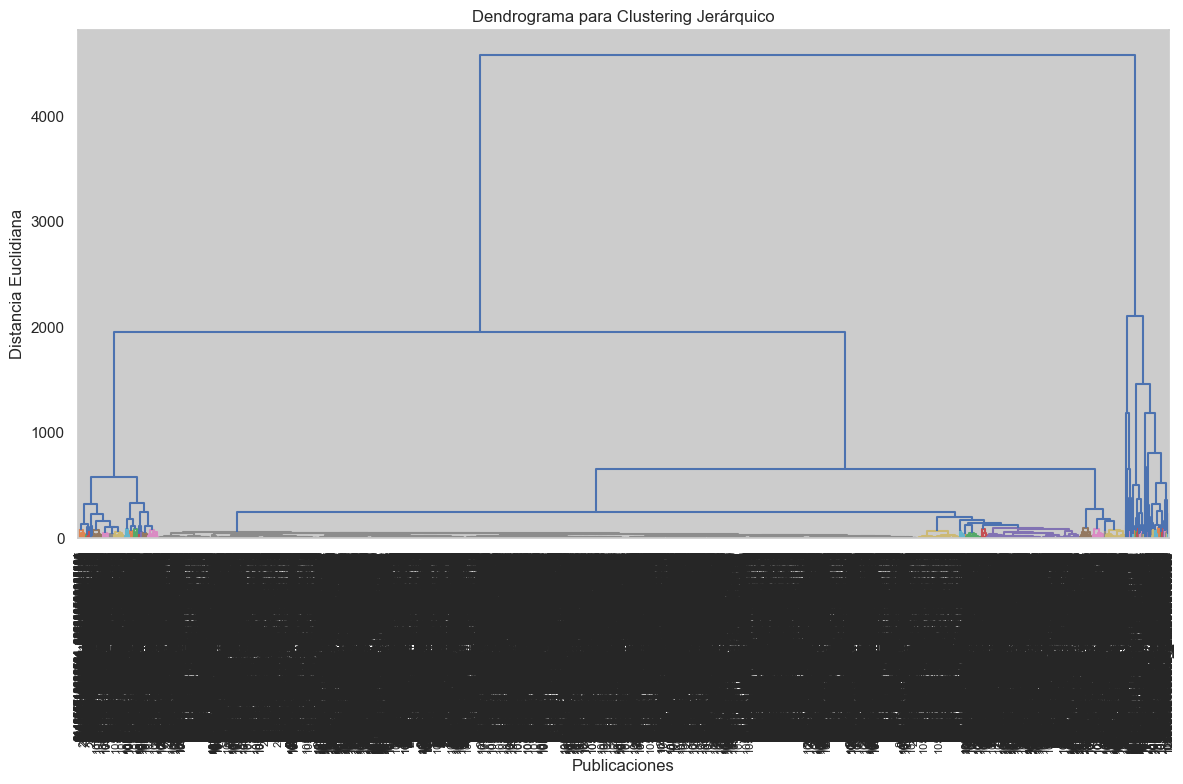

In [56]:
#calculamos la matriz de distancias
distance_matrix = distance.pdist(df_scaler, metric='euclidean')

#calculamos el enlace jerárquico
linkage_matrix = hierarchy.linkage(distance_matrix, method='ward')

#creamos el dendrograma
plt.figure(figsize=(12, 8))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=df_scaler.index, orientation='top', color_threshold=100, leaf_font_size=8)

#configuramos el gráfico  
plt.title('Dendrograma para Clustering Jerárquico')
plt.xlabel('Publicaciones')
plt.ylabel('Distancia Euclidiana')

plt.show()

A diferencia del kmeans, en dendrograma nos indica que tendríamos que utilizar dos clusters (si trazamos una línea horizontal desde y=2500, esta corta dos líneas verticales. Este número, 2, es el número de clusters sugerido por el dendrograma

Aplicaremos el método y añadiremos la columna resultante a nuestro dataset original limpio 

In [59]:
#aplicamos el método con 2 clusters y con las mismos argumentos que el dendrograma ('euclidean', 'ward')
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  

label_h = cluster.fit_predict(df_scaler)

#creamos una nueva columna en el dt limpio que contenga los labels producidos por la clusterización jerárquica 
df['label_h'] = label_h

## Descripción de los clusters - Clusterización Jerarquizada

En esta sección intentaremos realizar una descripción gráfica de los clusters teniendo en cuenta:

- tamaño de los clusters 
- distribución por tipo de publicación
- medias de las reacciones 
- años y horas del día 

Finalmente intentaremos sintentizar las diferencias entre cada uno de los clusters

Cluster 1: 6770 observaciones
Cluster 0: 280 observaciones


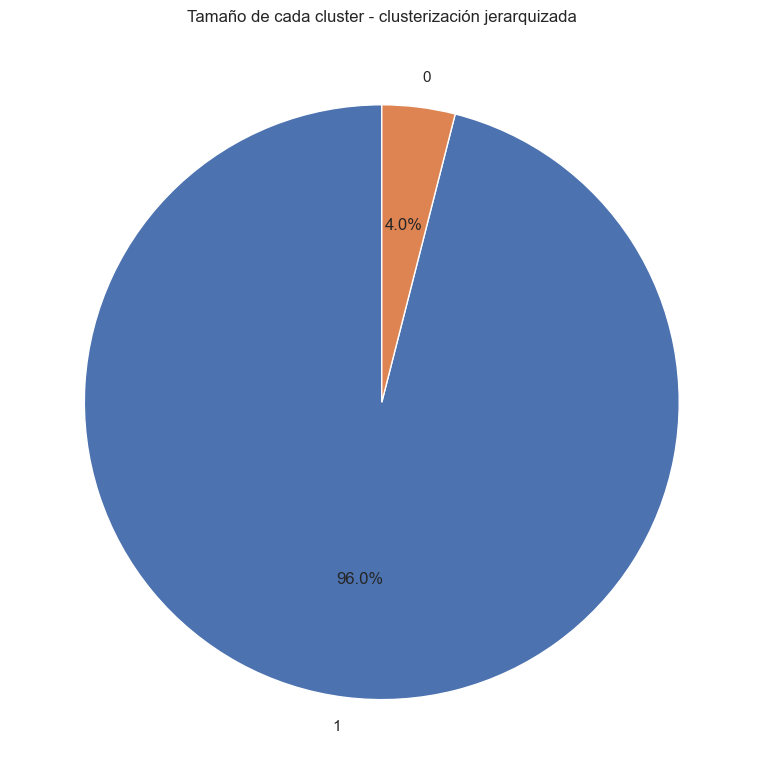

In [66]:
#contamos el número de observaciones por cluster
cluster_counts = df['label_h'].value_counts()
messages = [f'Cluster {label}: {count} observaciones' for label, count in cluster_counts.items()]

#imprimimos la información
for message in messages:
    print(message)

#creamos un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)

#configuramos el título
plt.title('Tamaño de cada cluster - Clusterización Jerarquizada')

# Mostrar el gráfico
plt.show()

El cluster 0 representa tan solo el 4% de las observaciones
El cluster 1 representa el 96% de las observaciones

<Figure size 1200x800 with 0 Axes>

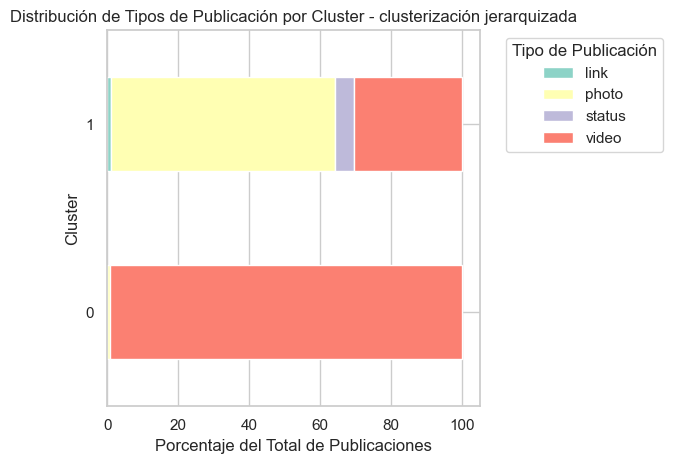

In [67]:
#Distribución de los tipos de publicación en cada cluster 

#escogemos los colores 
colores = sns.color_palette('Set3', n_colors=len(df['status_type'].unique()))

#contamos el tipo de publicación por cluster
conteo_tipo_publicacion = df.groupby(['label_h', 'status_type']).size().unstack()

#normalizamos
conteo_tipo_porcentaje = conteo_tipo_publicacion.div(conteo_tipo_publicacion.sum(axis=1), axis=0) * 100

#escogemos un estilo 
sns.set(style="whitegrid")

#creamos el gráfico
plt.figure(figsize=(12, 8))
conteo_tipo_porcentaje.plot(kind='barh', stacked=True, color=colores)

#configuramos
plt.title('Distribución de Tipos de Publicación por Cluster - Clusterización Jerarquizada')
plt.xlabel('Porcentaje del Total de Publicaciones')
plt.ylabel('Cluster')

# Ajustar leyenda
plt.legend(title='Tipo de Publicación', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

El cluster 0, el más pequeño contiene publicaciones de video y una muy pequeña parte de fotos. 
El cluster 1, distribuye los tipos de publicación de la misma manera que el dataset original 

In [64]:
#Distribución por reacciones (columnas numéricas)

#calculamos los valores medios por cada columna
mean_values = df.groupby('label_h')[columnas_numericas].mean()

print(mean_values)

         num_comments  num_shares   num_likes   num_loves   num_wows  \
label_h                                                                
0         3454.364286  517.203571  543.528571  139.357143  16.300000   
1           90.766322   20.286854  201.457312    7.491433   0.668538   

         num_hahas  num_sads  num_angrys  
label_h                                   
0         7.982143  2.089286    1.100000  
1         0.395126  0.167356    0.072378  


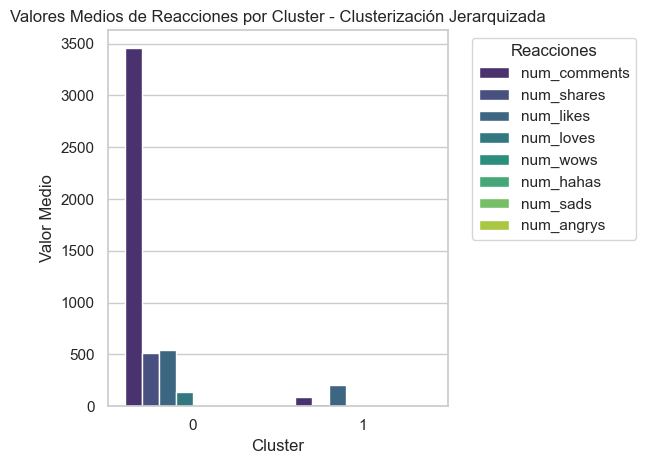

In [68]:
#determinamos la media de reacciones por cluster 
media_reacciones = df.groupby('label_h')[columnas_numericas].mean().reset_index()


#creamos un gráfico de barras agrupadas
plt.figure()
sns.barplot(data=media_reacciones.melt(id_vars='label_h'), x='label_h', y='value', hue='variable', palette='viridis')

#configuramos el gráfico
plt.title('Valores Medios de Reacciones por Cluster - Clusterización Jerarquizada')
plt.xlabel('Cluster')
plt.ylabel('Valor Medio')
plt.legend(title='Reacciones', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

En cuanto a las medias de las reacciones podemos detectar que: 
   - El cluster 0 incluye las publicaciones que tienen una media de reacciones más altas. En este caso, podríamos llamar a este cluster - viral 
   - El cluster 1 incluye el resto de publicaciones no virales

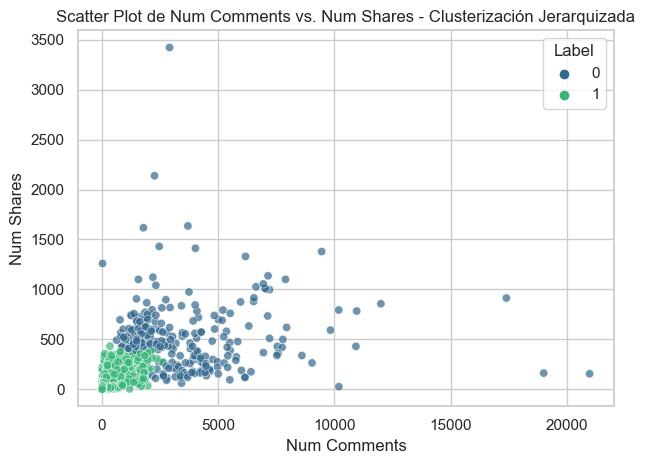

In [70]:
#creamos el scatter con comments y shares
sns.scatterplot(x='num_comments', y='num_shares', hue='label_h', data=df, alpha=0.7, palette='viridis')

#configuramos el gráfico
plt.title('Scatter Plot de Num Comments vs. Num Shares - Clusterización Jerarquizada')
plt.xlabel('Num Comments')
plt.ylabel('Num Shares')
plt.legend(title='Label')

plt.show()

En el scatter podemos observar que los dos clusters están bien delimitados, aunque el cluster 0 está mucho más disperso. Esto nos lleva a pensar que la escogencia de 3 clusters propuesta por el kmeans era mucho más acertada


<Figure size 1200x800 with 0 Axes>

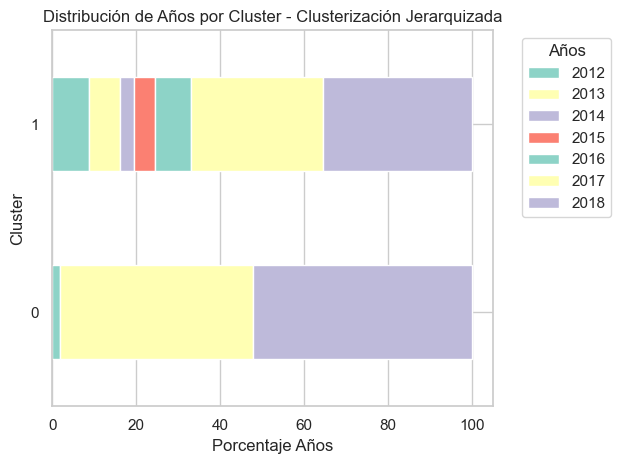

In [71]:
#distribución por año 

#escogemos los colores 
colores = sns.color_palette('Set3', n_colors=len(df['status_type'].unique()))

#contamos el tipo de publicación por cluster
conteo_año = df.groupby(['label_h', 'año']).size().unstack()

#normalizamos
conteo_año_porcentaje = conteo_año.div(conteo_año.sum(axis=1), axis=0) * 100

#escogemos un estilo 
sns.set(style="whitegrid")

#creamos el gráfico
plt.figure(figsize=(12, 8))
conteo_año_porcentaje.plot(kind='barh', stacked=True, color=colores)

#configuramos
plt.title('Distribución de Años por Cluster - Clusterización Jerarquizada')
plt.xlabel('Porcentaje Años')
plt.ylabel('Cluster')

# Ajustar leyenda
plt.legend(title='Años', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

Según los años: 
    - En el cluster 0 tenemos publicaciones de los años 2017 y 2018 y una pequeña fracción de publicaciones del 2012
    - En el cluster 1 tenemos publicaciones de todos los años
    

<Figure size 1200x800 with 0 Axes>

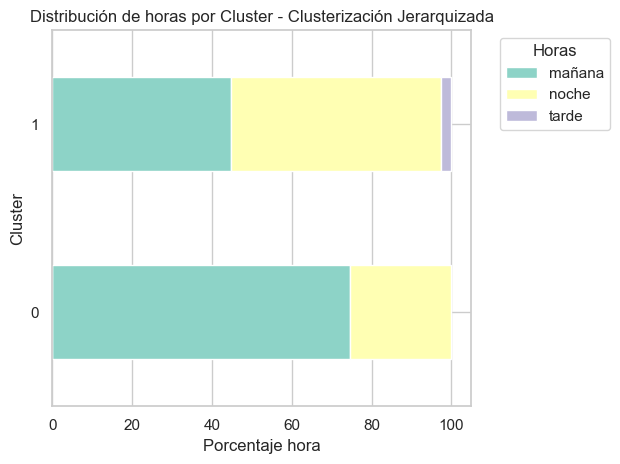

In [73]:
#distribución por hora 

#escogemos los colores 
colores = sns.color_palette('Set3', n_colors=len(df['status_type'].unique()))

#contamos el tipo de publicación por cluster
conteo_hora = df.groupby(['label_h', 'categoria_hora']).size().unstack()

#normalizamos
conteo_hora_porcentaje = conteo_hora.div(conteo_hora.sum(axis=1), axis=0) * 100

#escogemos un estilo 
sns.set(style="whitegrid")

#creamos el gráfico
plt.figure(figsize=(12, 8))
conteo_hora_porcentaje.plot(kind='barh', stacked=True, color=colores)

#configuramos
plt.title('Distribución de horas por Cluster - Clusterización Jerarquizada')
plt.xlabel('Porcentaje hora')
plt.ylabel('Cluster')

# Ajustar leyenda
plt.legend(title='Horas', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

Por hora: 
   - En el cluster 0 tenemos publicaciones realizadas mayoritariamente en horas de la mañana 
   - En el cluster 1 tenemos publicaciones realizadas en los tres momentos del día con la misma distribución del data set original limpio

En resumen, 

Cluster 0 - viral: 
- representa tan solo el 4% del dataset. 
- las medias de los valores de las reacciones son las mas altas. Es decir, este cluster agrupa principalmente las publicaciones más virales. 
- incluye publicaciones de video hechas principalmente en las mañanas de los años 2017, 2018 y algunas de 2012. 

Cluster 1 - viral: 
   - al representar el 96% del dataset original su contenido es muy parecido similar. 
   - las medias de los valores de las columnas de las reacciones son inferiores a las del dataset original.    

# Conclusiones 

La utilización de los métodos de análisis no supervisado en este dataset nos sirvió para detectar patrones que nos permiten distinguir entre publicaciones en facebook más y menos virales. 

Sin embargo, los dos algoritmos utilizados produjeron resultados ligeramente diferentes: 

- Kmeans detectó 3 clusters. Así agrupó las observaciones en conjuntos de publicaciones muy virales, otras algo populares y la mayoría, que son publicaciones con muy pocas reacciones. 

- La clusterización jerárquica solo detectó 2 clusters, agrupando los datos en un conjunto muy pequeño de publiaciones virales y el resto. 

La disparidad entre los resultados de los dos métodos también nos lleva a pensar cuáles serían los criterios para establecer cuándo una publicación es viral y cuándo no. También, intentar definir mejor ese tercer cluster que nos indicó el Kmeans: las publicaciones que son populares pero que no alcanzan el estatus de virales. 